# This notebook contains code for creating and evaluating the baseline model and subsequent models

In [1]:
reset -fs

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sqlalchemy import create_engine
import sqlite3 as sql
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score,recall_score,precision_score,fbeta_score,make_scorer,roc_auc_score,roc_curve,confusion_matrix,precision_recall_curve,classification_report
from sklearn.feature_selection import SelectFromModel

import imblearn.over_sampling
import imblearn.under_sampling

In [3]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [4]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in dataset for modeling

In [5]:
subjects_incidents = pd.read_csv('nypd_force_df_rev2.csv')

In [6]:
subjects_incidents.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'subject_age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force', 'occurrence_date',
       ...
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
       'member_injured_all_Y', 'race_diff_all_Y', 'race_diff_Y',
       'subject_injured_target'],
      dtype='object', length=101)

In [7]:
subjects_incidents['subject_injured_target'].value_counts()

0    31589
1      683
Name: subject_injured_target, dtype: int64

Drop rows with NaN in the subject age column, since logistic regression can't handle NaNs

In [8]:
subjects_incidents_no_null = subjects_incidents.dropna()

Create dataframe of features I'll actually use (plus subject_id and tri_incident_number, which are needed for splitting into train/val/split) and the target variable

In [12]:
df_X = subjects_incidents_no_null[['subject_id','tri_incident_number','subject_age',
                                   'num_subjects','num_members','race_diff_all_Y',
                                   'member_injured_all_Y',
       'member_injured_Y','race_diff_Y','subject_used_force_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','subject_injured_target']]

# Model Preparation

First, since I'm using logistic regression and I have numeric variables on different scales, I need to standardize them so they're on the same scale.

In [13]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_58496/1532820943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])


Next, I split my dataset twice: first, into training and test sets and then, from the training set into training and validation sets.

In [42]:
# split the data into train/validate/test sets with stratified sampling
    # to ensure the same proportion of the target variable in each set

# train-test split
X_train, X_te, y_train, y_te = train_test_split(df_X.iloc[:,1:], df_X['subject_injured_target'], test_size=0.2, stratify=df_X['subject_injured_target'], random_state=42)

# train-val split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [43]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{df_X["subject_injured_target"].value_counts() / len(df_X)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_tr.value_counts() / len(y_tr)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_val.value_counts() / len(y_val)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{y_te.value_counts() / len(y_te)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
0    0.978603
1    0.021397
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
0    0.978581
1    0.021419
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
0    0.978635
1    0.021365
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
0    0.978638
1    0.021362
Name: subject_injured_target, dtype: float64


Now that I have my dataset ready, I can create a helper function that will allow me to cross-validate, create an ROC curve to plot it calculate the ROC AUC score, and create confusion matrices.

In [45]:
def cross_validate_roc_cm(model, X_train, y_train, X_validate, y_validate):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recall scores: {(cv_results['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results['test_f2_score'])):.3f}")
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_validate, model.predict_proba(X_validate)[:,1]) # lr.predict_proba(X_validate)[:,1] means use probabilities for the positive outcome only

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')

    # axis labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for serious subject injury problem')
    plt.legend()
    plt.show()
    print("ROC AUC score = ", roc_auc_score(y_validate, model.predict_proba(X_validate)[:,1]))
    
    # create and plot confusion matrix with training data
    con_mat = confusion_matrix(y_train, model.predict(X_train))
    plt.figure(dpi=100)
    sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Training data')
    plt.show()
    
    # create and plot confusion matrix with validation data
    con_mat_val = confusion_matrix(y_validate, model.predict(X_validate))
    plt.figure(dpi=100)
    sns.heatmap(con_mat_val, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Validation data')
    plt.show()

I'm ready to create my baseline model!

# Baseline Logistic Regression Model

- subject's age
- whether member suffered an injury
- whether subject used force against member
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment

In [46]:
X_tr_1 = X_tr[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER']]

X_val_1 = X_val[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER']]

In [127]:
lr_base = LogisticRegression(solver='liblinear',max_iter=10000,random_state=42)
lr_base.fit(X_tr_1,y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.04347826 0.02531646 0.09195402]

mean recall: 0.064

f2 scores: [0.11254019 0.08241758 0.05263158 0.03125    0.11111111]

mean f2 score: 0.078


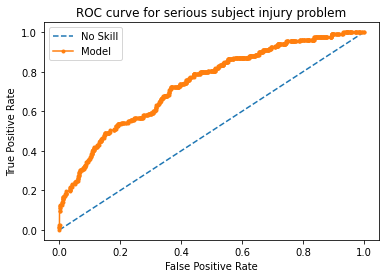

ROC AUC score =  0.7385175430368436


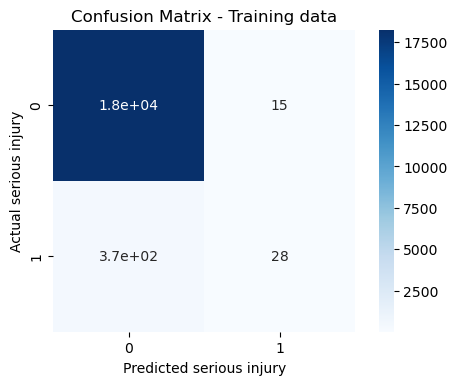

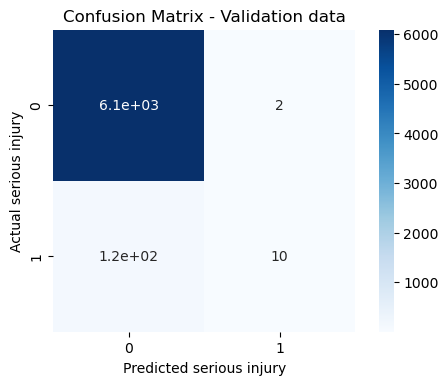

In [128]:
cross_validate_roc_cm(lr_base, X_tr_1,y_tr,X_val_1, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070

# LR Model 2 

- subject's age
- whether member suffered an injury
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment
- type of force used against member (if any)

In [49]:
X_tr_2 = X_tr[['subject_age',
       'member_injured_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
              'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']]

X_val_2 = X_val[['subject_age',
       'member_injured_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
              'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']]

In [52]:
lr_2 = LogisticRegression(solver='liblinear',max_iter=10000, random_state=42)
lr_2.fit(X_tr_2, y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.05797101 0.05063291 0.08045977]

mean recall: 0.070

f2 scores: [0.11182109 0.08241758 0.06968641 0.0623053  0.09749304]

mean f2 score: 0.085


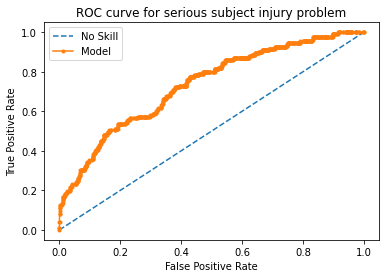

ROC AUC score =  0.7335831782344897


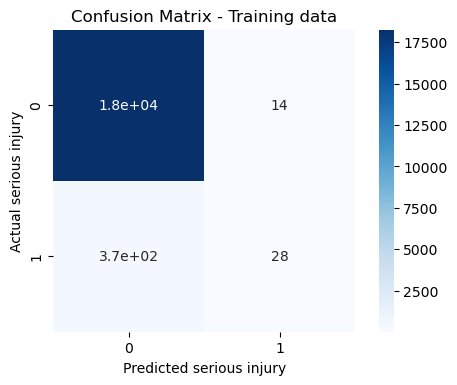

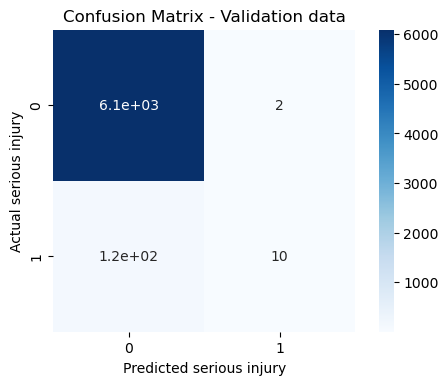

In [53]:
cross_validate_roc_cm(lr_2, X_tr_2,y_tr,X_val_2, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085

# LR model 3 

- subject's age
- whether member suffered an injury
- whether subject used force against member of service
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment
- number of subjects involved in incident
- number of members involved in incident

In [54]:
X_tr_3 = X_tr[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','num_members','num_subjects']]

X_val_3 = X_val[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

In [55]:
lr_3 = LogisticRegression(solver='liblinear',max_iter=10000, random_state=42)
lr_3.fit(X_tr_3, y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.05797101 0.02531646 0.09195402]

mean recall: 0.067

f2 scores: [0.11254019 0.08264463 0.06993007 0.03125    0.11111111]

mean f2 score: 0.081


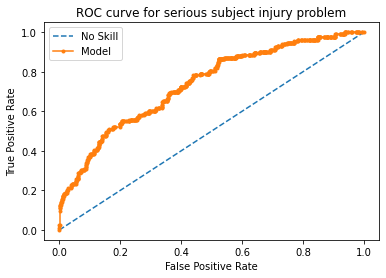

ROC AUC score =  0.7370691995912302


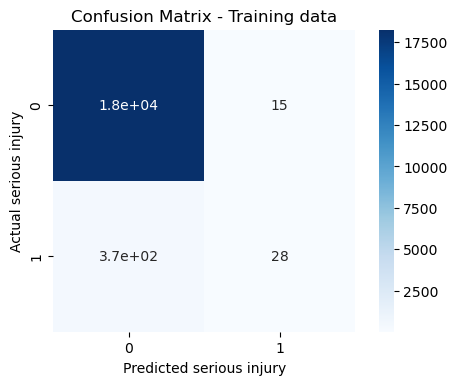

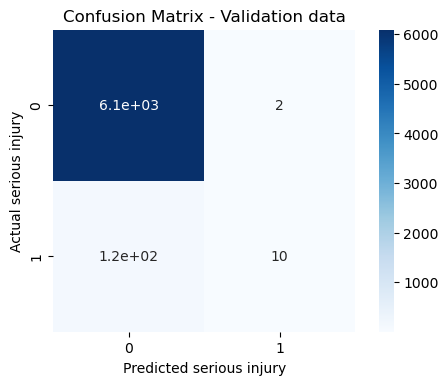

In [56]:
cross_validate_roc_cm(lr_3, X_tr_3,y_tr,X_val_3, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081

# LR model 4 (same features as model 3)

- balanced class weights

In [57]:
lr_4 = LogisticRegression(class_weight = 'balanced', solver='liblinear',max_iter=10000)
lr_4.fit(X_tr_3, y_tr)

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

recall scores: [0.56578947 0.64044944 0.52173913 0.6835443  0.63218391]

mean recall: 0.609

f2 scores: [0.15820456 0.18590998 0.13605442 0.18711019 0.19097222]

mean f2 score: 0.172


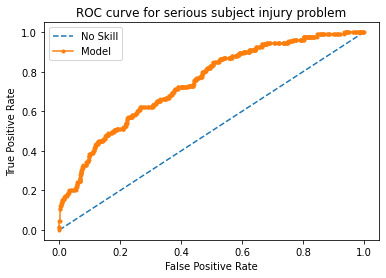

ROC AUC score =  0.7444732152113704


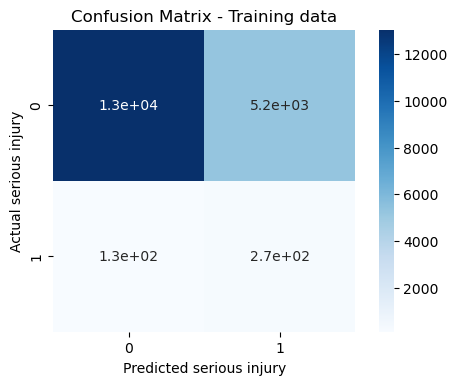

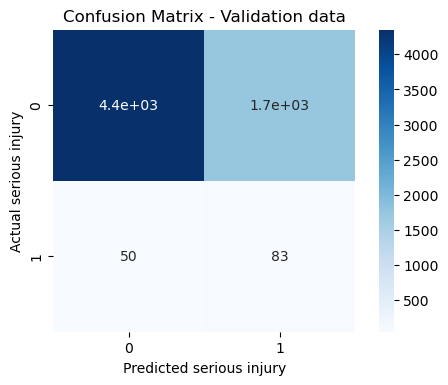

In [58]:
cross_validate_roc_cm(lr_4, X_tr_3, y_tr,X_val_3, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171

# LR model 5 (same features as model 3)

- random over sampling

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Logistic Regression Model best F2 score 0.224 at ratio = 27 to 1


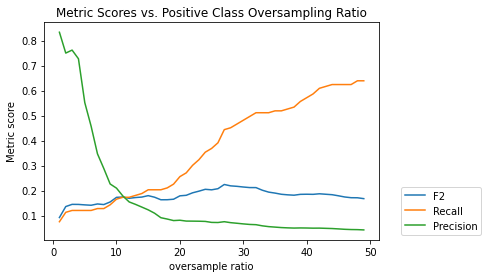

In [64]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue

ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os, y_tr_os = ROS.fit_resample(X_tr_3, y_tr)
    
    lr = LogisticRegression(solver='liblinear',max_iter=10000)
    lr.fit(X_tr_3_os,y_tr_os)
    
    f2_scores.append(fbeta_score(y_val, lr.predict(X_val_3), beta=2))    
    rec_scores.append(recall_score(y_val, lr.predict(X_val_3)))
    prec_scores.append(precision_score(y_val, lr.predict(X_val_3)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Logistic Regression Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

In [65]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 27, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os, y_tr_os = ROS.fit_resample(X_tr_3, y_tr)

In [66]:
lr_5 = LogisticRegression(solver='liblinear',max_iter=10000)
lr_5.fit(X_tr_3_os,y_tr_os)

LogisticRegression(max_iter=10000, solver='liblinear')

recall scores: [0.42525534 0.43729295 0.4487061  0.45351044 0.43387881]

mean recall: 0.440

f2 scores: [0.45855026 0.47094801 0.48112179 0.48681128 0.46969262]

mean f2 score: 0.473


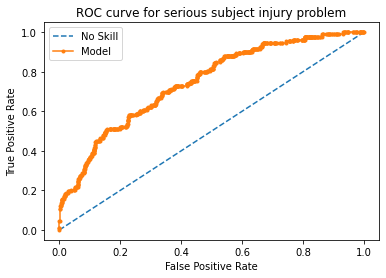

ROC AUC score =  0.7464442458740416


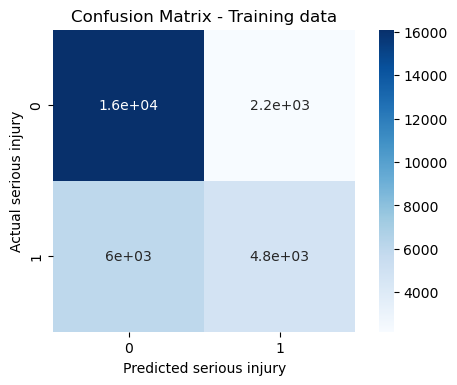

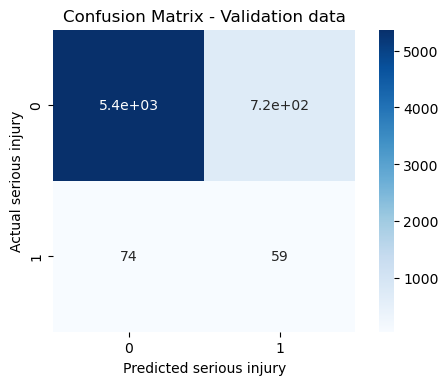

In [67]:
cross_validate_roc_cm(lr_5,X_tr_3_os,y_tr_os,X_val_3,y_val)

In [136]:
X_te_3 = X_te[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

In [138]:
y_predict_lr_5 = (lr_5.predict_proba(X_te_3)[:,1])
print("Threshold of 0.3:")
print("Precision:{:6.4f},Recall:{:6.4f},F2:{:6.4f}".format(precision_score(y_te, np.round(y_predict_lr_5)), 
                                                     recall_score(y_te, np.round(y_predict_lr_5)),
                                                     fbeta_score(y_te, np.round(y_predict_lr_5), beta=2)))

Threshold of 0.3:
Precision:0.0573,Recall:0.3383,F2:0.1708


- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171
        
        
- LR model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- LR model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- LR model 5: mean F2 score from cross-validation: .473

# LR model 6 (same features as model 3)

- SMOTE (synthetic minority oversampling technique)

In [73]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 27, 0 : n_neg} 

In [76]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_3_smote, y_tr_smote = smote.fit_resample(X_tr_3, y_tr)

In [78]:
lr_6 = LogisticRegression(solver='liblinear',random_state = 42) 
lr_6.fit(X_tr_3_smote, y_tr_smote)

LogisticRegression(random_state=42, solver='liblinear')

recall scores: [0.74605385 0.74491245 0.72781885 0.73956357 0.73816895]

mean recall: 0.739

f2 scores: [0.75880631 0.7540481  0.74362606 0.75110811 0.75234403]

mean f2 score: 0.752


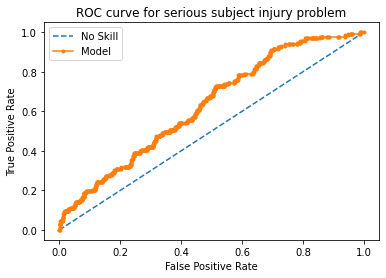

ROC AUC score =  0.6305385097675246


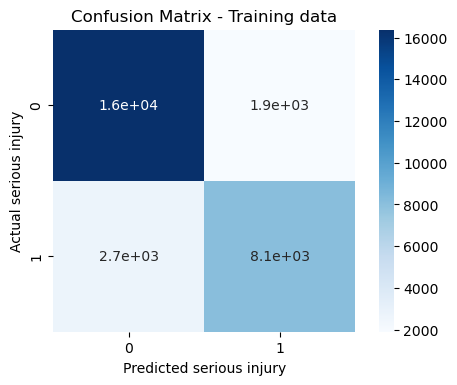

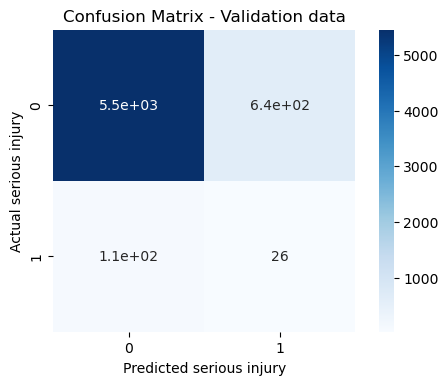

In [79]:
cross_validate_roc_cm(lr_6,X_tr_3_smote,y_tr_smote,X_val_3,y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171
        
        
- LR model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- LR model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- LR model 5: mean F2 score from cross-validation: .473
        
        
- LR model 6: Precision rate with validation data: 26/(26/640) = 26/666 = .039
- LR model 6: Recall rate with validation data: 26/(26+110) = 26/136 = .191
- LR model 6: mean F2 score from cross-validation: .752

# LR model 7 (same features as model 3)

- optimal class_weights and value of C from gridsearch

In [172]:
# I got help with writing this code from this webpage: https://developpaper.com/using-class-weight-to-improve-class-imbalance/

lr_weight_c = LogisticRegression(solver='liblinear')

#Define scoring metrics
f2_score = make_scorer(fbeta_score, beta=2)

#Set the range of class weights
weights = np.linspace(0.0,0.99,200)

#Set the range of C values
c_values = np.linspace(.10,10,100)

#Create dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights], 'C': c_values}

##Fitting training data with grid search method
gridsearch_weight_c = GridSearchCV(estimator= lr_weight_c, 
                          param_grid= param_grid,
                          n_jobs=-1, 
                          scoring=f2_score, 
                          refit=False).fit(X_tr_3, y_tr)

In [173]:
gridsearch_weight_c.best_params_

{'C': 0.9, 'class_weight': {0: 0.03979899497487437, 1: 0.9602010050251256}}

In [174]:
best_c = gridsearch_weight_c.best_params_['C']
best_class_weight = gridsearch_weight_c.best_params_['class_weight']

In [296]:
lr_7 = LogisticRegression(C=0.9,class_weight={0: 0.03979899497487437, 1: 0.9602010050251256},solver='liblinear',max_iter=10000)
lr_7.fit(X_tr_3,y_tr)

LogisticRegression(C=0.9,
                   class_weight={0: 0.03979899497487437, 1: 0.9602010050251256},
                   max_iter=10000, solver='liblinear')

recall scores: [0.28947368 0.3258427  0.27536232 0.32911392 0.33333333]

mean recall: 0.311

f2 scores: [0.16058394 0.20480226 0.1496063  0.20344288 0.21545319]

mean f2 score: 0.187


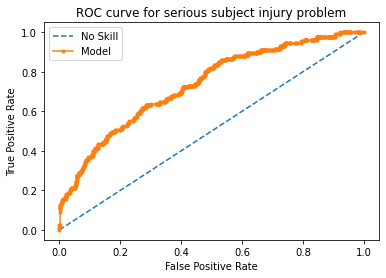

ROC AUC score =  0.7344267596107801


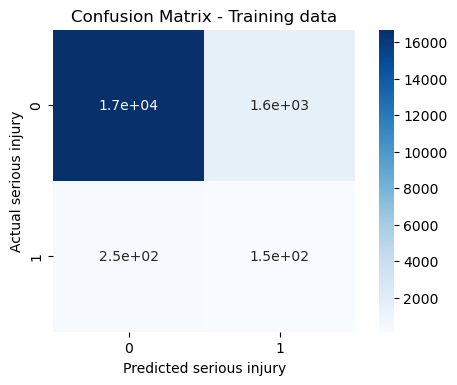

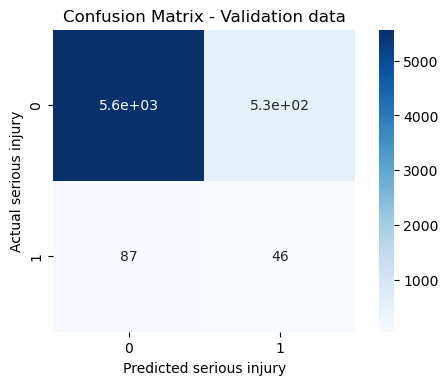

In [297]:
cross_validate_roc_cm(lr_7,X_tr_3,y_tr,X_val_3,y_val)

- Base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Base model: mean F2 score from cross-validation: .070


- Model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Model 2: mean F2 score from cross-validation: .085


- Model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Model 3: mean F2 score from cross-validation: .081


- Model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- Model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- Model 4: mean F2 score from cross-validation: .171
        
        
- Model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- Model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- Model 5: mean F2 score from cross-validation: .473
        
        
- Model 6: Precision rate with validation data: 26/(26/640) = 26/666 = .039
- Model 6: Recall rate with validation data: 26/(26+110) = 26/136 = .191
- Model 6: mean F2 score from cross-validation: .752
        
        
- Model 7: Precision rate with validation data: 46/(46+530) = 46/576 = .080
- Model 7: Recall rate with validation data: 46/(46+87) = 46/133 = .346
- Model 7: mean F2 score from cross-validation: .184

# Base Random Forest model (same features as lr model 3)

In [86]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_tr_3, y_tr)

RandomForestClassifier(random_state=42)

recall scores: [0.22368421 0.23595506 0.2173913  0.21518987 0.2183908 ]

mean recall: 0.222

f2 scores: [0.25993884 0.27559055 0.25167785 0.25373134 0.25333333]

mean f2 score: 0.259


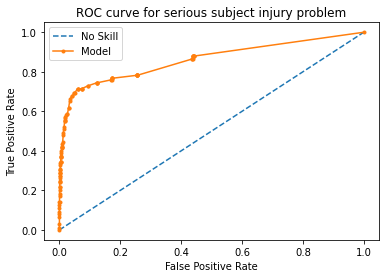

ROC AUC score =  0.8604906471694667


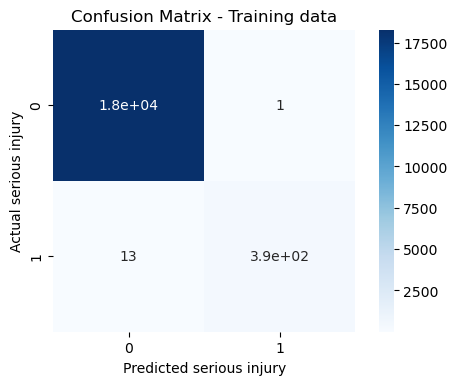

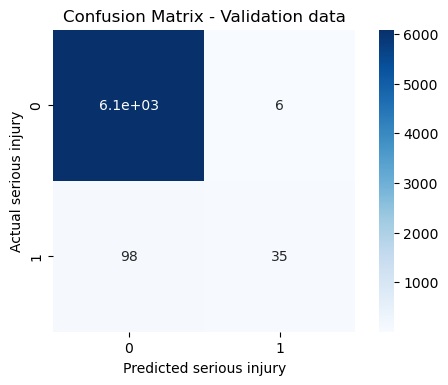

In [87]:
cross_validate_roc_cm(rf_base, X_tr_3,y_tr, X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259

# Random Forest Model 2 (same features as lr model 3)

- balanced class weights

In [93]:
rf_2 = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rf_2.fit(X_tr_3,y_tr)

RandomForestClassifier(class_weight='balanced', random_state=42)

recall scores: [0.18421053 0.16853933 0.2173913  0.16455696 0.2183908 ]

mean recall: 0.191

f2 scores: [0.21538462 0.20107239 0.25       0.1951952  0.2540107 ]

mean f2 score: 0.223


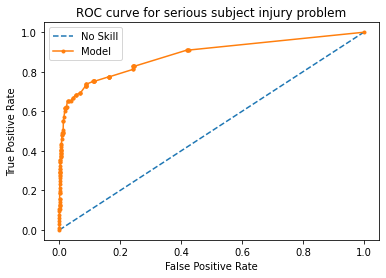

ROC AUC score =  0.8831790984355177


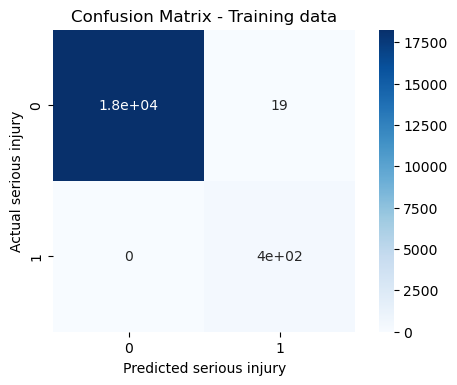

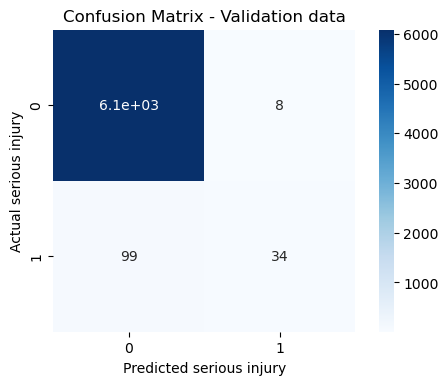

In [94]:
cross_validate_roc_cm(rf_2,X_tr_3,y_tr,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223

# Random Forest Model 3 (same features as lr model 3)

- random over sampling

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Random Forest Model best F2 score 0.388 at ratio = 47 to 1


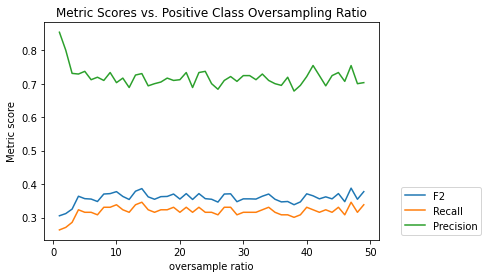

In [101]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue
    
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os_rf, y_tr_os_rf = ROS.fit_resample(X_tr_3, y_tr)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_3_os_rf,y_tr_os_rf)
    
    f2_scores.append(fbeta_score(y_val, rf.predict(X_val_3), beta=2))    
    rec_scores.append(recall_score(y_val, rf.predict(X_val_3)))
    prec_scores.append(precision_score(y_val, rf.predict(X_val_3)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Random Forest Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

In [112]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 14, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf, y_tr_os_rf = ROS.fit_resample(X_tr_3, y_tr)

In [113]:
rf_3 = RandomForestClassifier(random_state=42)
rf_3.fit(X_tr_3_os_rf,y_tr_os_rf)

RandomForestClassifier(random_state=42)

recall scores: [1. 1. 1. 1. 1.]

mean recall: 1.000

f2 scores: [0.99823944 0.99743308 0.99653221 0.99670511 0.9965035 ]

mean f2 score: 0.997


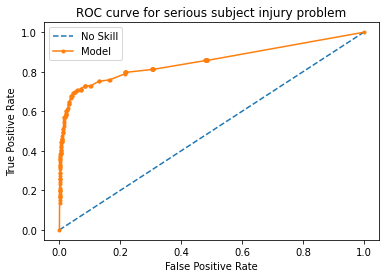

ROC AUC score =  0.8528120202015215


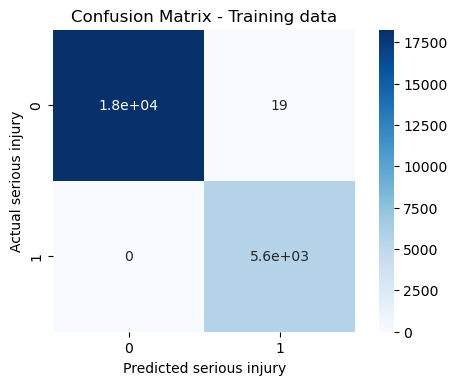

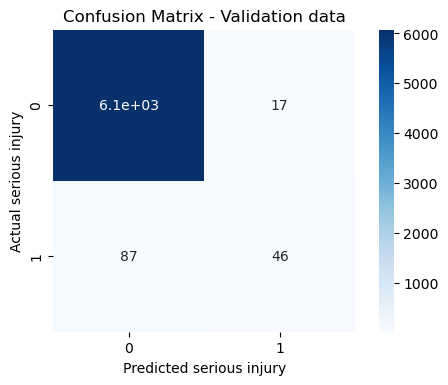

In [114]:
cross_validate_roc_cm(rf_3,X_tr_3_os_rf,y_tr_os_rf,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997

In [ ]:
#plotting a precision/recall curve for different probability thresholds with
#our predictions

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rf.predict(X_val_4)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as injured)');
plt.title('Precision and Recall Curves');

# Random Forest Model 4 (same features as lr model 3)

- smote

In [116]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 14, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_3_smote_rf, y_tr_smote_rf = smote.fit_resample(X_tr_3, y_tr)

In [117]:
rf_4 = RandomForestClassifier(random_state=42)
rf_4.fit(X_tr_3_smote_rf,y_tr_smote_rf)

RandomForestClassifier(random_state=42)

recall scores: [0.94620811 0.94577206 0.93315018 0.92837466 0.9197995 ]

mean recall: 0.935

f2 scores: [0.95293073 0.95260137 0.93951687 0.93645795 0.92942765]

mean f2 score: 0.942


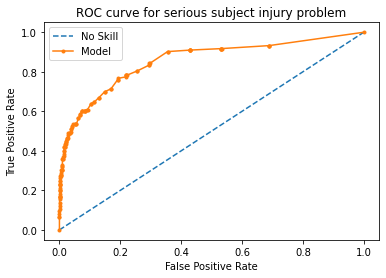

ROC AUC score =  0.8554939548477233


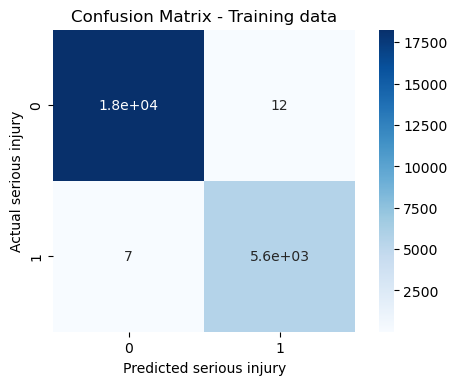

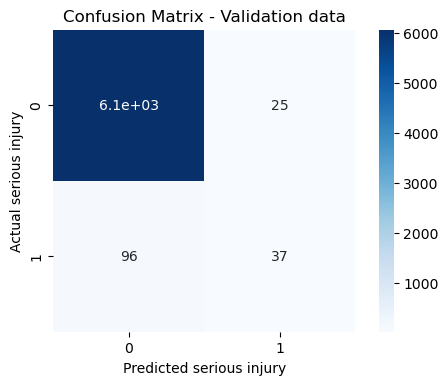

In [118]:
cross_validate_roc_cm(rf_4,X_tr_3_smote_rf,y_tr_smote_rf,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942

# Random Forest Model 5 (same features as lr model 3)

- balanced sub-sample class weights

recall scores: [0.18421053 0.19101124 0.24637681 0.17721519 0.1954023 ]

mean recall: 0.199

f2 scores: [0.21538462 0.22666667 0.28239203 0.20895522 0.22972973]

mean f2 score: 0.233


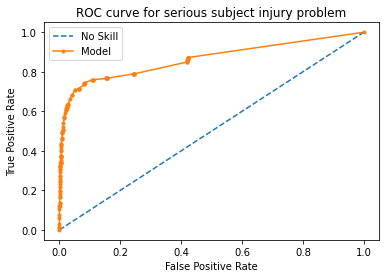

ROC AUC score =  0.8635521008693764


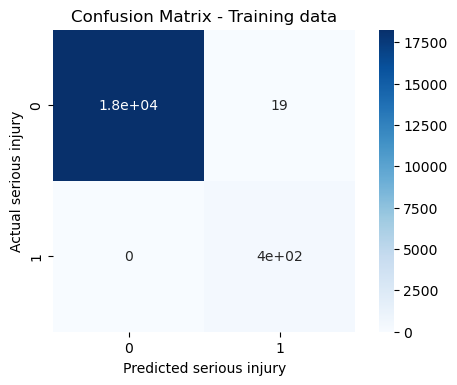

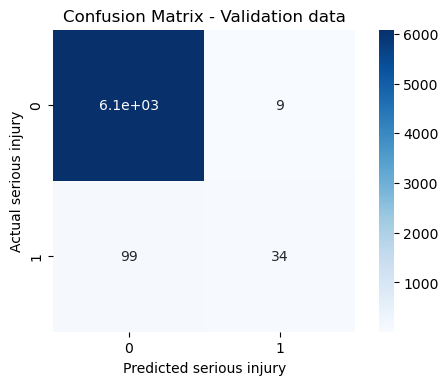

In [190]:
rf_5 = RandomForestClassifier(class_weight = 'balanced_subsample',random_state=42)
rf_5.fit(X_tr_3,y_tr)

cross_validate_roc_cm(rf_5,X_tr_3,y_tr,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942
        
        
- RF Model 5: Precision rate with validation data: 34/(34+9) = .791
- RF Model 5: Recall rate with validation data: 34/(34+99) = .256
- RF Model 5: mean F2 score from cross-validation: .233

# Feature selection using randomly over-sampled data

In [218]:
sel = SelectFromModel(RandomForestClassifier(random_state=42))
sel.fit(X_tr_3_os_rf,y_tr_os_rf)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [219]:
sel.get_support()

array([ True,  True, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True])

In [220]:
selected_feat= X_tr_3.columns[(sel.get_support())]
len(selected_feat)

18

In [221]:
print(selected_feat)

Index(['subject_age', 'member_injured_Y', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects'],
      dtype='object')


# Random Forest Model 6 (selected features)

- random over-sampling and selected features

In [278]:
X_tr_3_sel = X_tr_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

X_val_3_sel = X_val_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Random Forest Model best F2 score 0.528 at ratio = 7 to 1


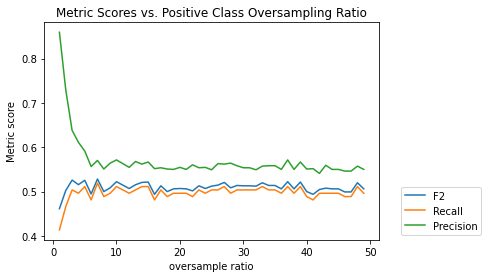

In [281]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue
    
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os_rf_sel, y_tr_os_rf_sel = ROS.fit_resample(X_tr_3_sel, y_tr)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_3_os_rf_sel,y_tr_os_rf_sel)
    
    f2_scores.append(fbeta_score(y_val, rf.predict(X_val_3_sel), beta=2))    
    rec_scores.append(recall_score(y_val, rf.predict(X_val_3_sel)))
    prec_scores.append(precision_score(y_val, rf.predict(X_val_3_sel)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Random Forest Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

In [282]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 7, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf_sel, y_tr_os_rf_sel = ROS.fit_resample(X_tr_3_sel, y_tr)

recall scores: [0.99440299 1.         0.98934281 0.99084249 0.99509002]

mean recall: 0.994

f2 scores: [0.9866716  0.98443721 0.97959902 0.97759306 0.98605255]

mean f2 score: 0.983


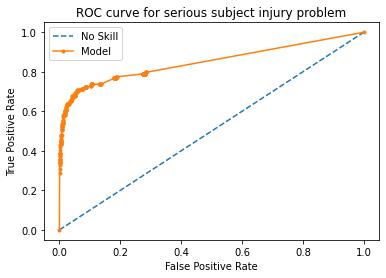

ROC AUC score =  0.8494235013008555


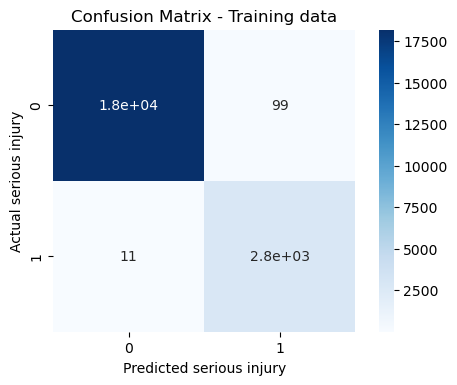

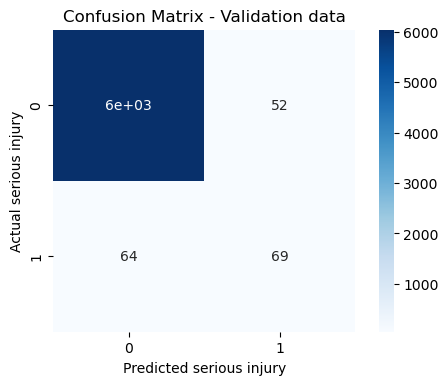

In [283]:
rf_6 = RandomForestClassifier(random_state=42)
rf_6.fit(X_tr_3_os_rf_sel,y_tr_os_rf_sel)

cross_validate_roc_cm(rf_6,X_tr_3_os_rf_sel,y_tr_os_rf_sel,X_val_3_sel,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942
        
        
- RF Model 5: Precision rate with validation data: 34/(34+9) = .791
- RF Model 5: Recall rate with validation data: 34/(34+99) = .256
- RF Model 5: mean F2 score from cross-validation: .233
        
        
- RF Model 6: Precision rate with validation data: 69/(69+52) = .570
- RF Model 6: Recall rate with validation data: 69/(69+64) = .519
- RF Model 6: mean F2 score from cross-validation: .983

In [284]:
X_te_3_sel = X_te_3[['subject_age','member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

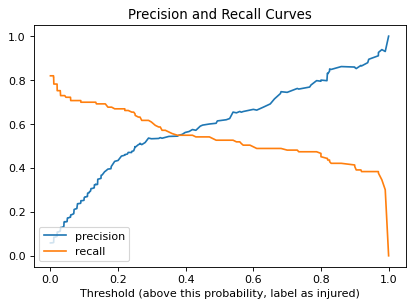

In [286]:
#plotting a precision/recall curve for different probability thresholds with
#our predictions

precision_curve,recall_curve,threshold_curve = precision_recall_curve(y_te,rf_6.predict_proba(X_te_3_sel)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as injured)');
plt.title('Precision and Recall Curves');

In [287]:
y_predict_rf_6 = (rf_6.predict_proba(X_te_3_sel)[:,1]>.25)
print("Precision:{:6.4f},Recall:{:6.4f},F2:{:6.4f}".format(precision_score(y_te, np.round(y_predict_rf_6)), 
                                                     recall_score(y_te, np.round(y_predict_rf_6)),
                                                     fbeta_score(y_te, np.round(y_predict_rf_6), beta=2)))

Precision:0.4943,Recall:0.6466,F2:0.6091


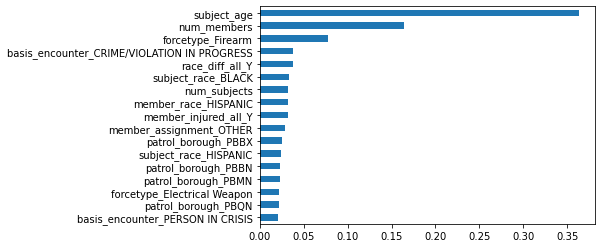

In [288]:
importances = rf_6.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

feat_importances = pd.Series(rf_6.feature_importances_, index=X_te_3_sel.columns)
ax = feat_importances.nlargest(17).plot(kind='barh')
ax.invert_yaxis()

In [274]:
X_te_3_sel['predicted_prob'] = y_predict_rf_6

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_58496/3047163984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_3_sel['predicted_prob'] = y_predict_rf_6


In [276]:
X_te_3_sel.predicted_prob.value_counts()

False    6074
True      152
Name: predicted_prob, dtype: int64

<AxesSubplot:xlabel='subject_injured_target', ylabel='subject_age'>

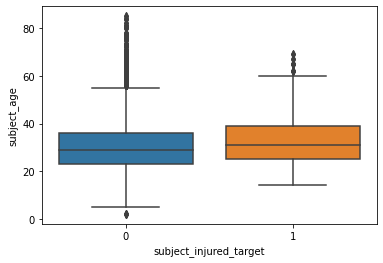

In [246]:
sns.boxplot(x='subject_injured_target', y='subject_age', data=subjects_incidents)

<AxesSubplot:xlabel='subject_injured_target', ylabel='num_members'>

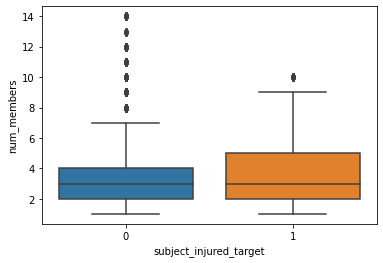

In [247]:
sns.boxplot(x='subject_injured_target', y='num_members', data=subjects_incidents)

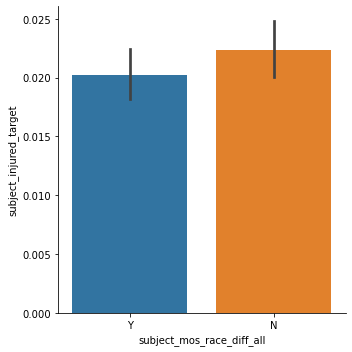

In [260]:
sns.catplot(x='subject_mos_race_diff_all',y='subject_injured_target',kind='bar',data=subjects_incidents)

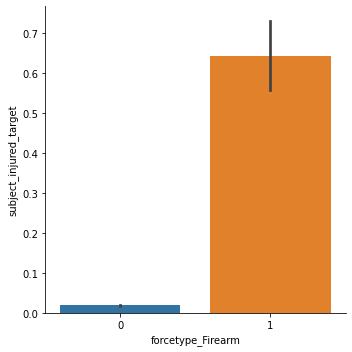

In [261]:
sns.catplot(x='forcetype_Firearm',y='subject_injured_target',kind='bar',data=subjects_incidents)